In [1]:
# Cargamos librerías
import pandas as pd 
import numpy as np
from pickle import TRUE

# silence warnings
import warnings
warnings.filterwarnings("ignore")

# plots
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

# Para mantener siempre el mismo entorno
import random
MYSEED=42
random.seed(MYSEED)

# acceso a sistema
import sys
import os 

# time calculation to track some processes
import time

# python core library for machine learning and data science
import sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

# manejo de datatime
import calendar
import datetime
from datetime import timedelta, datetime
from enum import IntEnum

# pretty aspect within a function
from IPython.display import display_html

# GLOBAL_VARIABLES
from platform import python_version
#CWD = os.getcwd()
#DATA_PATH = os.path.join(CWD, "../data_dsmarket/finales")

In [2]:
print("Working with these versions of libraries\n")
print(f"Numpy version {np.__version__}")
print(f"Pandas version {pd.__version__}")
print(f"Statsmodels version {sm.__version__}")
print(f"Python version {python_version()}")

#print("\nDirectorio actual\n",CWD)
#print("\nDirectorio con conjunto de datos\n",DATA_PATH)

Working with these versions of libraries

Numpy version 1.21.5
Pandas version 1.4.2
Statsmodels version 0.13.2
Python version 3.9.12


In [3]:
# Funciones

def datosGenerales(df):
    # Vemos un shape
    print("Su shape",df.shape);

    # vemos número de duplicados
    print("El número de duplicados es ",\
          df.duplicated().sum());
    
    # vemos recuento de nulos y si los hay, vemos su porcentaje
    return df.isnull().sum().apply(lambda row:
                                    f"{row} nulos, {round(row / df.shape[0]*100,2)} %"
                                       if row != 0 else f"{row} nulos ________")
    
def cambioFormato(dataset, atributos, tipo):
    dataset[atributos] = dataset[atributos].astype(tipo)
    
def count_sales_cat(column):
    list =df[column].unique()
    for i in list:
        df_items['ventas_en_'+i] = df.groupby('item').apply(lambda x: np.sum(x[x[column] == i]['weekly_sales']))
        
def plot_dummies(attr):
    display_html(df[df[attr]==1].head(3))
    sns.relplot(x='yearweek',
                y='weekly_sales',
                hue='category',
                data=df[df[attr]==1],
                kind='line',
                height=8.27,
                aspect=11.7/8.27)
    
def prepEvents(df_ref,attr):
    tmp_attr=df.groupby(['item',attr])['weekly_sales'].sum().reset_index()
    tmp_attr_venta=tmp_attr[tmp_attr[attr]==1]
    df_ref=pd.merge(left=df_ref,
                      right=tmp_attr_venta,
                      left_on='item',
                      right_on='item')
    df_ref.drop(attr,axis=1,inplace=True)
    df_ref.rename(columns={'weekly_sales':f"venta_{attr}"},inplace=True)
    return df_ref

In [4]:
%%time
# Cargamos fichero pickle
# Éste proviene del fichero DS_market_20230218_rawData.ipynb
df = pd.read_pickle(r'C:\TESIS\df_final20230317.pkl')

CPU times: total: 1.22 s
Wall time: 2.64 s


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8323770 entries, 0 to 8323769
Data columns (total 22 columns):
 #   Column            Dtype   
---  ------            -----   
 0   yearweek          int32   
 1   id                object  
 2   item              category
 3   category          category
 4   store             category
 5   store_code        category
 6   region            category
 7   weekly_sales      int32   
 8   estacion          object  
 9   week_event        int64   
 10  Predidents_day    uint8   
 11  Ramadan_starts    uint8   
 12  San_Patricio      uint8   
 13  San_Valentin      uint8   
 14  Superbowl         uint8   
 15  Thanksgiving      uint8   
 16  Amazon_prime_day  uint8   
 17  dia_de_la_indep   uint8   
 18  dia_madre         uint8   
 19  dia_padre         uint8   
 20  sell_price        float64 
 21  revenue           float64 
dtypes: category(5), float64(2), int32(2), int64(1), object(2), uint8(10)
memory usage: 571.6+ MB


## Next step
You could start looking at the 
data from NY, Boston and Philly. My intuition says that we probably have **some products that are not 
so popular any more**, and it’s likely that most popular products vary across cities, or even across 
stores (which might vary in prices as well). Our marketing actions will be exploiting those 
differences. We need to understand every single detail of the business! 

Identify groups of products that behave in a similar way. Michelle was saying that with your magic it’s easy to identify groups of similar products, and such groups will be super useful to evaluate the performance of our different campaigns. How many groups do you think we should consider? 5? 10? 20? Also, do you think we could find a “solid” approach to identify how similar are stores to one another? Would store clustering also make sense here? Could you also do that?

**EVENTO SAN VALENTIN**

,yearweek,id,item,category,store,store_code,region,weekly_sales,estacion,week_event,...,San_Patricio,San_Valentin,Superbowl,Thanksgiving,Amazon_prime_day,dia_de_la_indep,dia_madre,dia_padre,sell_price,revenue
60980,201107,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,Greenwich_Village,NYC_1,New York,0,invierno,0,...,0,1,0,0,0,0,0,0,12.74,0.0
60981,201107,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,Greenwich_Village,NYC_1,New York,0,invierno,0,...,0,1,0,0,0,0,0,0,5.28,0.0
60982,201107,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,Greenwich_Village,NYC_1,New York,0,invierno,0,...,0,1,0,0,0,0,0,0,3.95,0.0


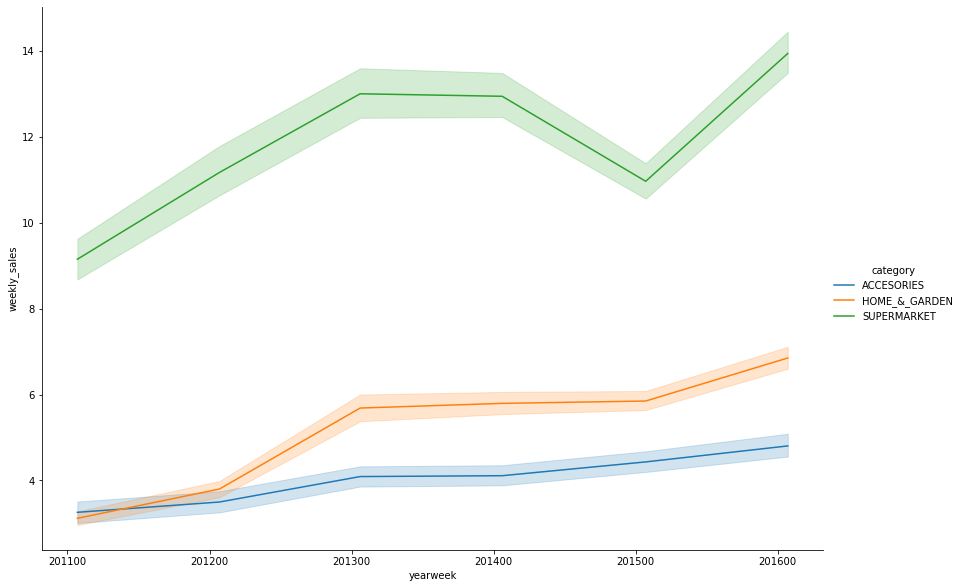

In [6]:
# Chequeo que coincida la semana con la fecha del evento.
# San Valentin semana 7/6 ( 14 de febrero)

# Comparando 14's de febrero, aumenta el consumo de home & garden
# con el paso de los años y fuerte crecimiento de pendiente en supermarket

plot_dummies('San_Valentin');

**dia de la madre**

,yearweek,id,item,category,store,store_code,region,weekly_sales,estacion,week_event,...,San_Patricio,San_Valentin,Superbowl,Thanksgiving,Amazon_prime_day,dia_de_la_indep,dia_madre,dia_padre,sell_price,revenue
426860,201119,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,Greenwich_Village,NYC_1,New York,0,primavera,0,...,0,0,0,0,0,0,1,0,12.74,0.0
426861,201119,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,Greenwich_Village,NYC_1,New York,0,primavera,0,...,0,0,0,0,0,0,1,0,5.28,0.0
426862,201119,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,Greenwich_Village,NYC_1,New York,0,primavera,0,...,0,0,0,0,0,0,1,0,3.95,0.0


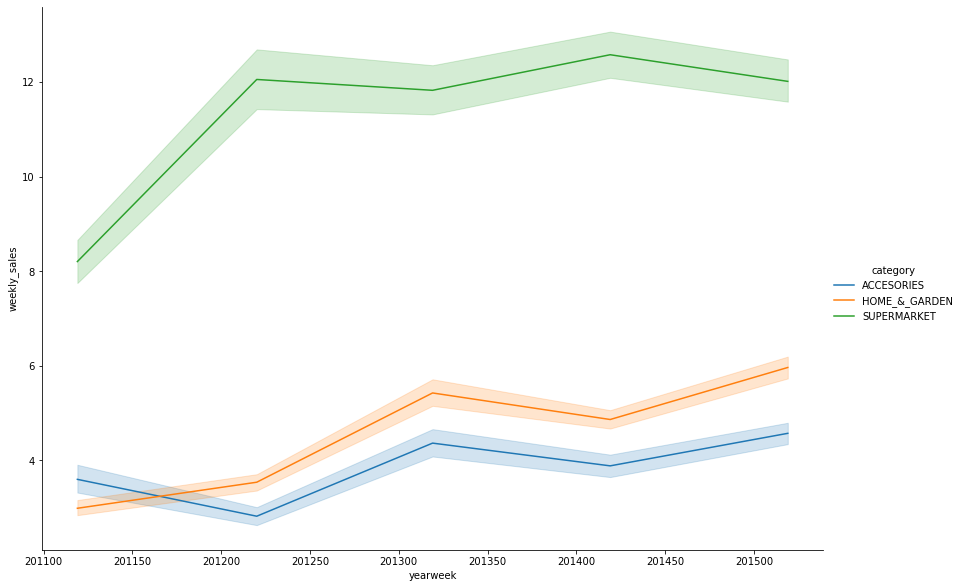

In [7]:
#comparando dia de la madre

plot_dummies('dia_madre');

**Thanksgiving**

,yearweek,id,item,category,store,store_code,region,weekly_sales,estacion,week_event,...,San_Patricio,San_Valentin,Superbowl,Thanksgiving,Amazon_prime_day,dia_de_la_indep,dia_madre,dia_padre,sell_price,revenue
1280580,201147,ACCESORIES_1_001_NYC_1,ACCESORIES_1_001,ACCESORIES,Greenwich_Village,NYC_1,New York,0,otoño,1,...,0,0,0,1,0,0,0,0,12.74,0.0
1280581,201147,ACCESORIES_1_002_NYC_1,ACCESORIES_1_002,ACCESORIES,Greenwich_Village,NYC_1,New York,0,otoño,1,...,0,0,0,1,0,0,0,0,5.28,0.0
1280582,201147,ACCESORIES_1_003_NYC_1,ACCESORIES_1_003,ACCESORIES,Greenwich_Village,NYC_1,New York,0,otoño,1,...,0,0,0,1,0,0,0,0,3.95,0.0


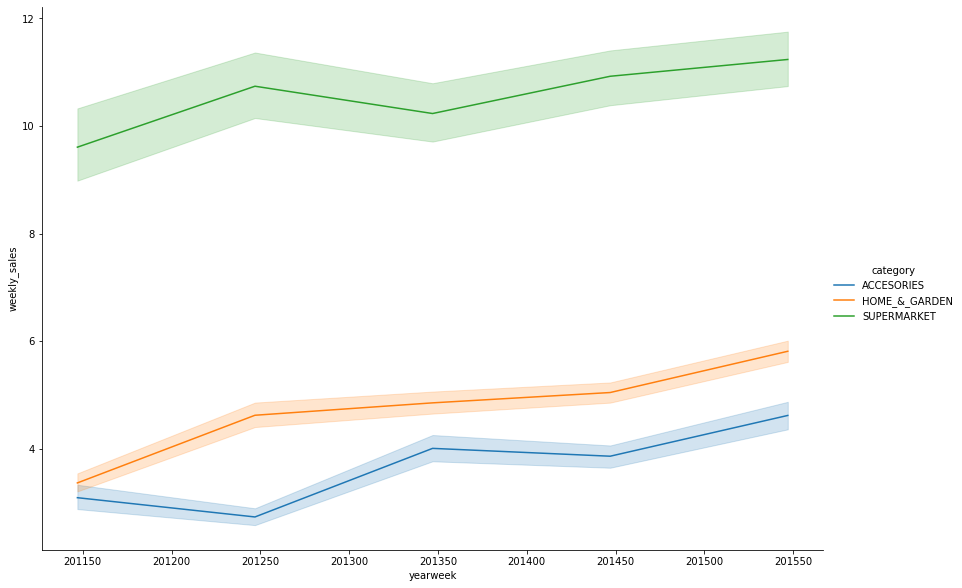

In [8]:
plot_dummies('Thanksgiving');

##### Vamos a armar variable de estaciones del año. Para eso tengo que separar la week

In [9]:
df['yearweek']=df['yearweek'].astype('str')

In [10]:
df['year']=df['yearweek'].str.slice(stop=4)
df['week']=df['yearweek'].str.slice(start=4)

In [11]:
df['week']=df['week'].astype('int')
df['year']=df['year'].astype('int')

In [12]:
item_estacion=df.groupby(['year','estacion','category'])['item'].size().reset_index()

In [13]:
#ventas_w=ventas_w.sort_values(['year','week'],ascending=True)

In [14]:
item_estacion

,year,estacion,category,item
0,2011,invierno,ACCESORIES,50850
1,2011,invierno,HOME_&_GARDEN,94230
2,2011,invierno,SUPERMARKET,129330
3,2011,otoño,ACCESORIES,73450
4,2011,otoño,HOME_&_GARDEN,136110
...,...,...,...,...
67,2016,primavera,HOME_&_GARDEN,31410
68,2016,primavera,SUPERMARKET,43110
69,2016,verano,ACCESORIES,0
70,2016,verano,HOME_&_GARDEN,0


In [15]:
df.groupby(['year','category'])['revenue'].sum().reset_index()

,year,category,revenue
0,2011,ACCESORIES,3517301.78
1,2011,HOME_&_GARDEN,8582680.97
2,2011,SUPERMARKET,17152040.37
3,2012,ACCESORIES,4676430.62
4,2012,HOME_&_GARDEN,11848217.42
5,2012,SUPERMARKET,24099184.39
6,2013,ACCESORIES,5838566.84
7,2013,HOME_&_GARDEN,13431049.16
8,2013,SUPERMARKET,24858256.88
9,2014,ACCESORIES,5911429.35


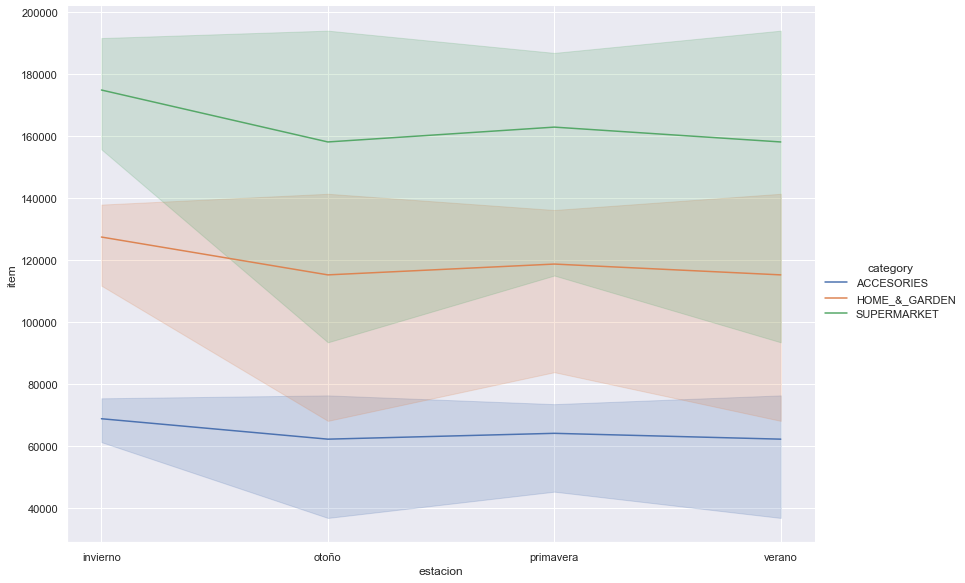

In [16]:
# No hay diferencia super marcada entre estaciones del año.
# En invierno Supermarket se vende mas, probablemente porque la
# gente se suele quedar mas adentro y se stockea.
# Home and garden, levemente baja en otoño. Invierno y verano 
# consumo mas alto. Si hacemos una moda para cada item, 
# va a dar todo invierno. Asi que no la voy a usar.

sns.set(rc = {'figure.figsize':(20,8)}) # esto no me funciona para cambiar el tamaño
sns.relplot(x='estacion',
            y='item',
            hue='category',
            data=item_estacion,
            kind='line',
            height=8.27,
            aspect=11.7/8.27);

In [17]:
df.groupby(['year','estacion'])['item'].size().to_frame().reset_index()

,year,estacion,item
0,2011,invierno,274410
1,2011,otoño,396370
2,2011,primavera,396370
3,2011,verano,396370
4,2012,invierno,426860
5,2012,otoño,396370
6,2012,primavera,396370
7,2012,verano,396370
8,2013,invierno,365880
9,2013,otoño,426860


##### NY lidera ventas, ciudad turistica. Habria que poner foco en las otras dos zonas. 
##### Las ventas son mas altas en invierno. Predominio de venta en cat supermarket.

In [18]:
# Consumo acumulado por ciudad
store_pivot_ = df.groupby(["store"])["weekly_sales"].sum()\
.sort_values(ascending = False).to_frame().reset_index()

# Acumulado
store_pivot_["cumsum_by_store"] = (store_pivot_["weekly_sales"]/store_pivot_["weekly_sales"].sum()).cumsum()

In [19]:
# El 20% de las ventas estan acumuladas en una tienda (Tribeca)
store_pivot_

,store,weekly_sales,cumsum_by_store
0,Tribeca,11173040,0.170329
1,Greenwich_Village,7686526,0.287508
2,Roxbury,7205609,0.397355
3,Yorktown,6533481,0.496956
4,Queen_Village,6418771,0.594808
5,Back_Bay,6081290,0.687516
6,Harlem,5673509,0.774006
7,South_End,5587559,0.859187
8,Midtown_Village,5139416,0.937536
9,Brooklyn,4097451,1.000000


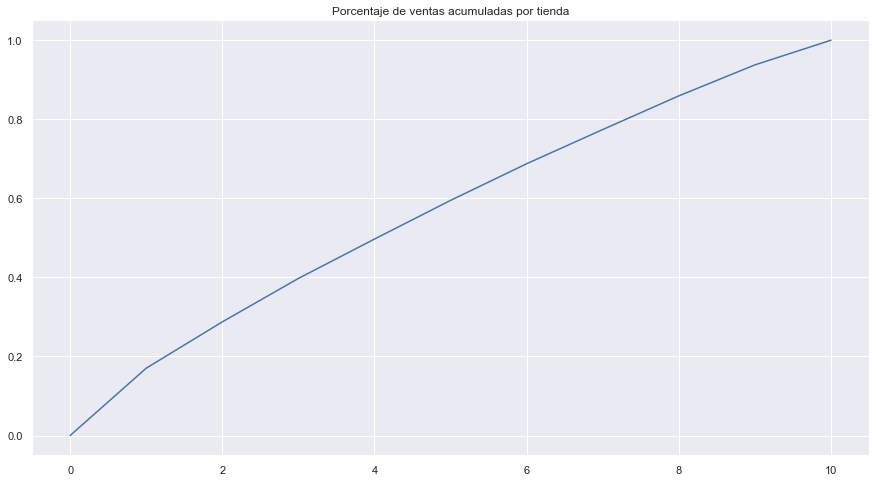

In [20]:
fig = plt.figure(figsize = (15, 8))
ax1 = fig.subplots(nrows = 1, ncols = 1)

# get the data
# concate a zero before the list, so that all curves start at origin
x1_values = [0] + list(store_pivot_.index)
y1_values = [0] + list(store_pivot_["cumsum_by_store"])

# plot the values and set for every subplot a title
ax1.plot(y1_values)
ax1.title.set_text("Porcentaje de ventas acumuladas por tienda")

In [21]:
# hacemos un groupby por order y calculamos algunas métricas básicas como max, min, media y similares.

df_items = df.groupby('item').agg(
    mean_week_ventas = ('weekly_sales', 'mean'),
    max_precio = ('sell_price', 'max'),
    min_precio = ('sell_price', 'min'),
    mean_precio = ('sell_price', 'mean'),
    total_ventas = ('weekly_sales', 'sum'),
    max_revenue = ('revenue', 'max'),
    min_revenue = ('revenue', 'min'),
    mean_revenue = ('revenue', 'mean'),
    total_revenue = ('revenue', 'sum'),
    max_sales_per_week = ('weekly_sales', 'max'), # cantidad se semanas con ventas
   # lastweek_purchase = ('yearweek', 'max'), no sirve pq todos los clusters tienen la misma ultima fecha de venta
   
)

In [22]:
df_items.head(3)

,mean_week_ventas,max_precio,min_precio,mean_precio,total_ventas,max_revenue,min_revenue,mean_revenue,total_revenue,max_sales_per_week
item,,,,,,,,,,
ACCESORIES_1_001,1.491941,12.74,6.65,11.470806,4073,142.82,0.0,16.415956,44815.56,13
ACCESORIES_1_002,1.849817,5.28,2.66,5.276634,5050,195.36,0.0,9.765586,26660.05,37
ACCESORIES_1_003,0.523077,7.94,1.25,3.947520,1428,51.35,0.0,2.061740,5628.55,13


In [23]:
df_items.describe().T

,count,mean,std,min,25%,50%,75%,max
mean_week_ventas,3049.0,7.880642,16.190489,0.207692,1.570696,3.485714,7.831136,3.667194e+02
max_precio,3049.0,5.975753,5.517399,0.300000,2.860000,4.420000,7.480000,1.341500e+02
min_precio,3049.0,3.634064,3.571830,0.010000,1.240000,2.400000,4.780000,3.588000e+01
mean_precio,3049.0,5.563617,4.533083,0.239502,2.621850,4.198297,7.180000,3.944650e+01
total_ventas,3049.0,21514.152837,44200.034077,567.000000,4288.000000,9516.000000,21379.000000,1.001144e+06
max_revenue,3049.0,252.303801,403.884044,3.990000,88.800000,146.730000,265.390000,9.406220e+03
min_revenue,3049.0,0.002643,0.145968,0.000000,0.000000,0.000000,0.000000,8.060000e+00
mean_revenue,3049.0,27.701850,41.418212,0.204147,7.937612,15.856553,30.649374,6.420177e+02
total_revenue,3049.0,75626.051233,113071.718697,557.320000,21669.680000,43288.390000,83672.790000,1.752708e+06
max_sales_per_week,3049.0,71.569367,137.578991,4.000000,18.000000,33.000000,69.000000,3.539000e+03


In [24]:
# Se ordena por categoría e item para saber cual es mas vendido
df.groupby(['category','item']).agg(
 venta_por_cat = ('weekly_sales', 'sum')

).sort_values(by='venta_por_cat',ascending=False)

venta_por_cat
category      item                            
SUPERMARKET   SUPERMARKET_3_090        1001144
              SUPERMARKET_3_586         919316
              SUPERMARKET_3_252         564572
              SUPERMARKET_3_555         490746
              SUPERMARKET_3_714         395709
...                                        ...
HOME_&_GARDEN SUPERMARKET_1_156              0
              SUPERMARKET_1_155              0
              SUPERMARKET_1_154              0
              SUPERMARKET_1_153              0
              SUPERMARKET_3_471              0

[9147 rows x 1 columns]

In [25]:
# Creamos ventas por region
count_sales_cat('region')

In [26]:
# Creamos ventas por estaciones del año
count_sales_cat('estacion')

In [27]:
# Creamos ventas por categoría
#count_sales_cat('category')

In [28]:
df_items.sample(5)

,mean_week_ventas,max_precio,min_precio,mean_precio,total_ventas,max_revenue,min_revenue,mean_revenue,total_revenue,max_sales_per_week,ventas_en_New York,ventas_en_Boston,ventas_en_Philadelphia,ventas_en_invierno,ventas_en_primavera,ventas_en_verano,ventas_en_otoño
item,,,,,,,,,,,,,,,,,
ACCESORIES_1_207,2.142491,3.70,3.36,3.602011,5849,51.27,0.0,7.630099,20830.17,15,1627,2026,2196,1504,1599,1556,1190
HOME_&_GARDEN_1_410,14.120879,5.59,1.88,5.337070,38550,704.68,0.0,73.465029,200559.53,142,16576,9956,12018,14725,5298,7454,11073
ACCESORIES_1_167,8.090476,1.01,0.66,0.915103,22087,94.06,0.0,7.214714,19696.17,104,6033,11193,4861,7376,4348,3862,6501
SUPERMARKET_2_258,3.987912,3.86,3.17,3.512458,10887,92.98,0.0,13.990505,38194.08,26,4432,2707,3748,3282,2951,2390,2264
SUPERMARKET_1_140,3.319414,8.38,2.38,8.307084,9062,184.27,0.0,27.571557,75270.35,22,4592,2022,2448,2587,1914,2029,2532


**EVENTOS**

In [29]:
# Todos se venden en eventos. Hay que ver cantidad vendida.
# Eso marca la diferencia entre items.
eventos=df.groupby(['item','week_event'])['weekly_sales'].sum().reset_index()

In [30]:
eventos

,item,week_event,weekly_sales
0,ACCESORIES_1_001,0,3659
1,ACCESORIES_1_001,1,414
2,ACCESORIES_1_002,0,4637
3,ACCESORIES_1_002,1,413
4,ACCESORIES_1_003,0,1263
...,...,...,...
6093,SUPERMARKET_3_825,1,1140
6094,SUPERMARKET_3_826,0,11057
6095,SUPERMARKET_3_826,1,1101
6096,SUPERMARKET_3_827,0,10157


In [31]:
venta_item_evento=eventos[eventos['week_event']==1]

In [32]:
venta_item_evento.head(2)

,item,week_event,weekly_sales
1,ACCESORIES_1_001,1,414
3,ACCESORIES_1_002,1,413


In [33]:
#agregamos columna con total ventas en evento.
df_items=pd.merge(left=df_items,
                  right=venta_item_evento,
                  left_on='item',
                  right_on='item')

In [34]:
df_items.rename(columns={'weekly_sales':'venta_en_eventos'},inplace=True)

In [35]:
df_items.drop('week_event',axis=1,inplace=True)

In [36]:
df_items.head(2)

,item,mean_week_ventas,max_precio,min_precio,mean_precio,total_ventas,max_revenue,min_revenue,mean_revenue,total_revenue,max_sales_per_week,ventas_en_New York,ventas_en_Boston,ventas_en_Philadelphia,ventas_en_invierno,ventas_en_primavera,ventas_en_verano,ventas_en_otoño,venta_en_eventos
0,ACCESORIES_1_001,1.491941,12.74,6.65,11.470806,4073,142.82,0.0,16.415956,44815.56,13,2520,1045,508,1140,767,953,1213,414
1,ACCESORIES_1_002,1.849817,5.28,2.66,5.276634,5050,195.36,0.0,9.765586,26660.05,37,1592,875,2583,1021,969,1304,1756,413


##### ESTO AHORA NO LO HAGO PQ ME DA QUE ESTAN EN EL MISMO CLUSTER TODOS.

**eventos eeuu**

In [37]:
df.columns

Index(['yearweek', 'id', 'item', 'category', 'store', 'store_code', 'region',
       'weekly_sales', 'estacion', 'week_event', 'Predidents_day',
       'Ramadan_starts', 'San_Patricio', 'San_Valentin', 'Superbowl',
       'Thanksgiving', 'Amazon_prime_day', 'dia_de_la_indep', 'dia_madre',
       'dia_padre', 'sell_price', 'revenue', 'year', 'week'],
      dtype='object')

In [38]:
tmp_list_eeuuEvents = ['Predidents_day',
                       'Ramadan_starts',
                       'San_Patricio',
                       'San_Valentin',
                       'Superbowl',
                       'Thanksgiving',
                       'Amazon_prime_day',
                       'dia_de_la_indep',
                       'dia_madre',
                       'dia_padre']
for i in tmp_list_eeuuEvents:
    df_items = prepEvents(df_items,i)

In [39]:
df_items.head(5)

,item,mean_week_ventas,max_precio,min_precio,mean_precio,total_ventas,max_revenue,min_revenue,mean_revenue,total_revenue,...,venta_Predidents_day,venta_Ramadan_starts,venta_San_Patricio,venta_San_Valentin,venta_Superbowl,venta_Thanksgiving,venta_Amazon_prime_day,venta_dia_de_la_indep,venta_dia_madre,venta_dia_padre
0,ACCESORIES_1_001,1.491941,12.74,6.65,11.470806,4073,142.82,0.0,16.415956,44815.56,...,84,70,93,87,80,86,32,69,55,59
1,ACCESORIES_1_002,1.849817,5.28,2.66,5.276634,5050,195.36,0.0,9.765586,26660.05,...,104,102,86,88,81,91,22,95,59,90
2,ACCESORIES_1_003,0.523077,7.94,1.25,3.947520,1428,51.35,0.0,2.061740,5628.55,...,35,24,42,44,41,22,16,26,18,26
3,ACCESORIES_1_004,14.331502,6.17,5.01,5.977311,39125,450.50,0.0,86.101989,235058.43,...,844,600,924,789,833,723,119,721,735,773
4,ACCESORIES_1_005,5.343590,4.10,2.00,3.837557,14588,141.61,0.0,20.344824,55541.37,...,217,288,205,265,298,270,44,253,183,284


In [40]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3049 entries, 0 to 3048
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   item                    3049 non-null   category
 1   mean_week_ventas        3049 non-null   float64 
 2   max_precio              3049 non-null   float64 
 3   min_precio              3049 non-null   float64 
 4   mean_precio             3049 non-null   float64 
 5   total_ventas            3049 non-null   int32   
 6   max_revenue             3049 non-null   float64 
 7   min_revenue             3049 non-null   float64 
 8   mean_revenue            3049 non-null   float64 
 9   total_revenue           3049 non-null   float64 
 10  max_sales_per_week      3049 non-null   int32   
 11  ventas_en_New York      3049 non-null   int64   
 12  ventas_en_Boston        3049 non-null   int64   
 13  ventas_en_Philadelphia  3049 non-null   int64   
 14  ventas_en_invierno      

In [41]:
df_items.set_index('item',inplace=True)

In [42]:
columns_list_df_item = df_items.columns

In [43]:
df_items.shape

(3049, 28)

In [44]:
columns_list_df_item

Index(['mean_week_ventas', 'max_precio', 'min_precio', 'mean_precio',
       'total_ventas', 'max_revenue', 'min_revenue', 'mean_revenue',
       'total_revenue', 'max_sales_per_week', 'ventas_en_New York',
       'ventas_en_Boston', 'ventas_en_Philadelphia', 'ventas_en_invierno',
       'ventas_en_primavera', 'ventas_en_verano', 'ventas_en_otoño',
       'venta_en_eventos', 'venta_Predidents_day', 'venta_Ramadan_starts',
       'venta_San_Patricio', 'venta_San_Valentin', 'venta_Superbowl',
       'venta_Thanksgiving', 'venta_Amazon_prime_day', 'venta_dia_de_la_indep',
       'venta_dia_madre', 'venta_dia_padre'],
      dtype='object')

In [45]:
# ver tema de outliers como comental Sol - ME DA ERROR
for i in columns_list_df_item:
    q = list(df_items[i].quantile([.05,.95]))
    df_items_sin_out = df_items[(df_items[i] >= q[0]) & (df_items[i] <= q[1])]

In [46]:
df_items_sin_out.shape

(2750, 28)

In [47]:
df_items_sin_out.isnull().sum()

mean_week_ventas          0
max_precio                0
min_precio                0
mean_precio               0
total_ventas              0
max_revenue               0
min_revenue               0
mean_revenue              0
total_revenue             0
max_sales_per_week        0
ventas_en_New York        0
ventas_en_Boston          0
ventas_en_Philadelphia    0
ventas_en_invierno        0
ventas_en_primavera       0
ventas_en_verano          0
ventas_en_otoño           0
venta_en_eventos          0
venta_Predidents_day      0
venta_Ramadan_starts      0
venta_San_Patricio        0
venta_San_Valentin        0
venta_Superbowl           0
venta_Thanksgiving        0
venta_Amazon_prime_day    0
venta_dia_de_la_indep     0
venta_dia_madre           0
venta_dia_padre           0
dtype: int64

In [48]:
CALCULATE_ELBOW = True

In [49]:
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()), # el imputer no hace falta porque no tenemos nulos
    ("StandardScaler", StandardScaler())
])

In [50]:
df_scaled_transformed = pipe.fit_transform(df_items_sin_out)

In [51]:
df_scaled_transformed

array([[-0.70302417,  1.18899422,  0.82126558, ..., -0.68843554,
        -0.73003951, -0.73829288],
       [-0.64033353, -0.14989488, -0.28757635, ..., -0.60301459,
        -0.71596284, -0.62712442],
       [-0.87274446,  0.32751061, -0.67942274, ..., -0.82970866,
        -0.86024878, -0.85663349],
       ...,
       [-0.09806276, -0.1534844 , -0.36261076, ..., -0.0182096 ,
        -0.05083984, -0.20038098],
       [-0.18423832, -0.82113419, -0.69331801, ..., -0.04449297,
         0.00898604,  0.11878007],
       [-0.23820231, -0.88215595, -0.86006115, ..., -0.6818647 ,
        -0.42035262, -0.75622327]])

In [52]:
df_scaled_transformed.shape # 2750 items y 28 dimensiones

(2750, 28)

In [53]:
# En cada iteraccion creo un Kmeans nuevo, despues fiteo para que aprenda
# los centroides del data frame anterior, y despues me guardo una métrica, 
# que en este caso es la inercia y cuando lo ploteo obtengo el elbow.

if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(2, 15):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k)

        clustering_model.fit(df_scaled_transformed)

        sse[k] = clustering_model.inertia_

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Fitting pipe with 12 clusters
Fitting pipe with 13 clusters
Fitting pipe with 14 clusters
Elbow curve took 0 minutes.


In [54]:
sse

{2: 37834.6789618366,
 3: 28610.17703249753,
 4: 24595.105754738273,
 5: 21536.23893027768,
 6: 19853.098095063382,
 7: 18461.926231985304,
 8: 17250.42034212077,
 9: 16205.080909645767,
 10: 15515.827800401985,
 11: 14497.827527784471,
 12: 13993.153278003974,
 13: 13408.19336631888,
 14: 13045.131566490483}

In [55]:
sse.keys()

dict_keys([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

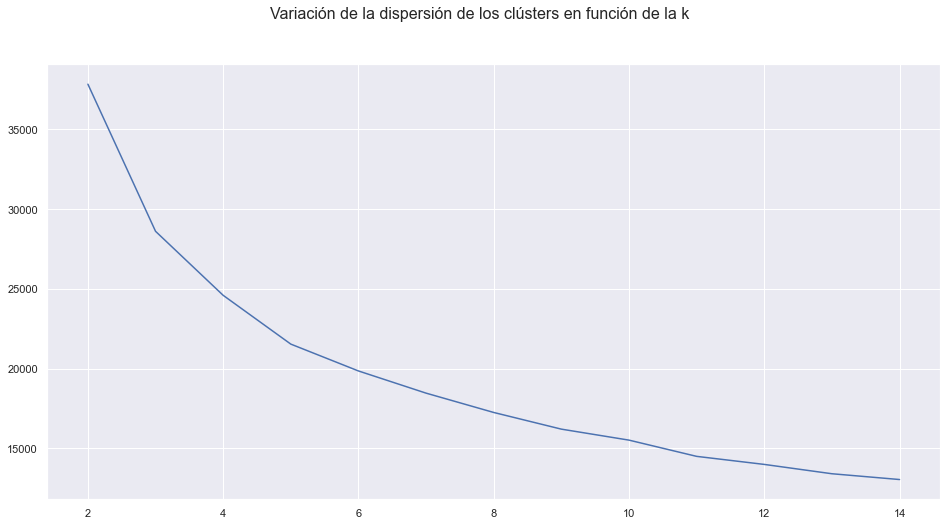

In [56]:
# Busco el cambio mas pronunciado de la pendiente.
# A partir de ahi, reduzco muy poco la dispersión.
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = sse.keys()
    y_values = sse.values()

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

In [57]:
# Con esto, ya re-entreno el pipeline
pipe = Pipeline(steps = [
    ("Imputer", KNNImputer()),
    ("StandardScaler", StandardScaler()),
    ("Clustering", KMeans(n_clusters = 4,random_state=MYSEED))
])

In [58]:
pipe.fit(df_items_sin_out)

Pipeline(steps=[('Imputer', KNNImputer()), ('StandardScaler', StandardScaler()),
                ('Clustering', KMeans(n_clusters=4, random_state=42))])

In [59]:
pipe['Clustering'].cluster_centers_

array([[ 0.72349285, -0.34532147, -0.32226982, -0.39284273,  0.72349285,
         0.27104627,  0.        ,  0.44430504,  0.44430504,  0.54112189,
         0.69744033,  0.63878011,  0.61490965,  0.70835056,  0.71794422,
         0.71860813,  0.68981701,  0.69581511,  0.70918   ,  0.71277493,
         0.70098876,  0.70093478,  0.68906457,  0.57588099,  0.5297393 ,
         0.68507128,  0.71185807,  0.70892073],
       [ 2.89764425, -0.45147431, -0.34753557, -0.52687185,  2.89764425,
         1.20003449,  0.        ,  1.61960157,  1.61960157,  2.35924066,
         2.64319222,  2.63762556,  2.59502559,  2.83706743,  2.85724918,
         2.81532442,  2.84167135,  2.8860682 ,  2.76701687,  2.808554  ,
         2.79639297,  2.73970794,  2.77469782,  2.52856524,  2.14502298,
         2.83230635,  2.74790242,  2.80074667],
       [-0.51545729,  1.91436086,  1.9505322 ,  2.10700662, -0.51545729,
         0.41237855,  0.        ,  0.48675027,  0.48675027, -0.46373273,
        -0.46974298, -0.4179

In [60]:
pipe['Clustering'].cluster_centers_.shape # 4 clusters y 17 variables

(4, 28)

In [61]:
# Ubicacion exacta de las 18 dimensiones para el 
# cluster 1 --> dónde ha hecho la conversión
pipe['Clustering'].cluster_centers_[0]

array([ 0.72349285, -0.34532147, -0.32226982, -0.39284273,  0.72349285,
        0.27104627,  0.        ,  0.44430504,  0.44430504,  0.54112189,
        0.69744033,  0.63878011,  0.61490965,  0.70835056,  0.71794422,
        0.71860813,  0.68981701,  0.69581511,  0.70918   ,  0.71277493,
        0.70098876,  0.70093478,  0.68906457,  0.57588099,  0.5297393 ,
        0.68507128,  0.71185807,  0.70892073])

In [62]:
# Estos centroides son calculados sin tener en cuenta los outliers.
# Pero cuando pongo etiquetas a los productos quiero que esté la
# base completa. Con el fit ya ha aprendido.

In [63]:
# Tengo que agarrar la base con outliers, y NO fitear en el standardscaler pq ya
# esta fiteado con la base sin outliers (transformo con la media sin outliers),
# directo al transform. Igual el Knn aca no tiene sentido porque no hay nulos.
X_processed = pipe[0].transform(df_items_sin_out)

X_scaled = pipe["StandardScaler"].transform(X_processed)
# perdemos clientes por el paso 3: clientes con más de 1 pedido o pago, se acaba agrupando en 1 único registro.

In [64]:
X_scaled.shape

(2750, 28)

In [65]:
X_processed.shape

(2750, 28)

In [66]:
# Valores escalados
X_scaled

array([[-0.70302417,  1.18899422,  0.82126558, ..., -0.68843554,
        -0.73003951, -0.73829288],
       [-0.64033353, -0.14989488, -0.28757635, ..., -0.60301459,
        -0.71596284, -0.62712442],
       [-0.87274446,  0.32751061, -0.67942274, ..., -0.82970866,
        -0.86024878, -0.85663349],
       ...,
       [-0.09806276, -0.1534844 , -0.36261076, ..., -0.0182096 ,
        -0.05083984, -0.20038098],
       [-0.18423832, -0.82113419, -0.69331801, ..., -0.04449297,
         0.00898604,  0.11878007],
       [-0.23820231, -0.88215595, -0.86006115, ..., -0.6818647 ,
        -0.42035262, -0.75622327]])

In [67]:
# Ya con el modelo escalado, le pido las etiquetas
labels = pipe["Clustering"].predict(X_scaled)

In [68]:
#3018 items 
labels.shape 

(2750,)

In [69]:
# Y va  a decir a qué cluster pertenece
labels

array([2, 3, 3, ..., 3, 3, 3])

In [70]:
X_processed

array([[  1.49194139,  12.74      ,   6.65      , ...,  69.        ,
         55.        ,  59.        ],
       [  1.84981685,   5.28      ,   2.66      , ...,  95.        ,
         59.        ,  90.        ],
       [  0.52307692,   7.94      ,   1.25      , ...,  26.        ,
         18.        ,  26.        ],
       ...,
       [  4.94542125,   5.26      ,   2.39      , ..., 273.        ,
        248.        , 209.        ],
       [  4.45347985,   1.54      ,   1.2       , ..., 265.        ,
        265.        , 298.        ],
       [  4.14542125,   1.2       ,   0.6       , ...,  71.        ,
        143.        ,  54.        ]])

In [71]:
X_processed = pd.DataFrame(X_processed)

In [72]:
X_processed.columns = df_items.columns

In [73]:
X_processed

,mean_week_ventas,max_precio,min_precio,mean_precio,total_ventas,max_revenue,min_revenue,mean_revenue,total_revenue,max_sales_per_week,...,venta_Predidents_day,venta_Ramadan_starts,venta_San_Patricio,venta_San_Valentin,venta_Superbowl,venta_Thanksgiving,venta_Amazon_prime_day,venta_dia_de_la_indep,venta_dia_madre,venta_dia_padre
0,1.491941,12.74,6.65,11.470806,4073.0,142.82,0.0,16.415956,44815.56,13.0,...,84.0,70.0,93.0,87.0,80.0,86.0,32.0,69.0,55.0,59.0
1,1.849817,5.28,2.66,5.276634,5050.0,195.36,0.0,9.765586,26660.05,37.0,...,104.0,102.0,86.0,88.0,81.0,91.0,22.0,95.0,59.0,90.0
2,0.523077,7.94,1.25,3.947520,1428.0,51.35,0.0,2.061740,5628.55,13.0,...,35.0,24.0,42.0,44.0,41.0,22.0,16.0,26.0,18.0,26.0
3,14.331502,6.17,5.01,5.977311,39125.0,450.50,0.0,86.101989,235058.43,73.0,...,844.0,600.0,924.0,789.0,833.0,723.0,119.0,721.0,735.0,773.0
4,5.343590,4.10,2.00,3.837557,14588.0,141.61,0.0,20.344824,55541.37,41.0,...,217.0,288.0,205.0,265.0,298.0,270.0,44.0,253.0,183.0,284.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,5.630769,3.58,1.19,3.349282,15372.0,327.36,0.0,18.618462,50828.40,110.0,...,457.0,243.0,322.0,402.0,383.0,256.0,102.0,218.0,230.0,206.0
2746,3.046520,3.22,2.40,3.030747,8317.0,115.78,0.0,9.301593,25393.35,36.0,...,177.0,180.0,186.0,173.0,168.0,111.0,8.0,227.0,159.0,233.0
2747,4.945421,5.26,2.39,4.938106,13501.0,264.00,0.0,24.060440,65685.00,55.0,...,362.0,267.0,381.0,547.0,389.0,138.0,63.0,273.0,248.0,209.0
2748,4.453480,1.54,1.20,1.539875,12158.0,50.69,0.0,6.840370,18674.21,33.0,...,214.0,276.0,208.0,198.0,259.0,151.0,78.0,265.0,265.0,298.0


In [74]:
X_processed['cluster'] = labels

In [75]:
#agregamos el ID para saber a qué cluster corresopnde cada producto
X_processed['id']=df_items_sin_out.index

In [76]:

X_processed[['id','cluster']].head()

,id,cluster
0,ACCESORIES_1_001,2
1,ACCESORIES_1_002,3
2,ACCESORIES_1_003,3
3,ACCESORIES_1_004,0
4,ACCESORIES_1_005,3


In [77]:
separacion=X_processed["id"].str.split('_', expand=True)

In [78]:
X_processed=pd.concat([X_processed, separacion], axis=1)
dropear=[1,2,3,4]
X_processed.drop(dropear,axis=1,inplace=True)
X_processed.rename(columns={0:'category'},inplace=True)

In [79]:
X_processed['category'].value_counts()

SUPERMARKET    1288
HOME            954
ACCESORIES      508
Name: category, dtype: int64

In [80]:
#datos a tener en cuenta para ver qué categorias hay dentro de cada cluster
cat_por_cluster=X_processed.groupby('cluster')['category'].value_counts().to_frame()

In [81]:
cat_por_cluster

category
cluster category             
0       SUPERMARKET       411
        HOME              168
        ACCESORIES         43
1       SUPERMARKET       130
        HOME               30
        ACCESORIES         19
2       HOME              135
        ACCESORIES        133
        SUPERMARKET        41
3       SUPERMARKET       706
        HOME              621
        ACCESORIES        313

In [83]:
#cat_por_cluster.to_excel('cat_por_cluster.xlsx')

In [84]:
centroids=pipe['Clustering'].cluster_centers_

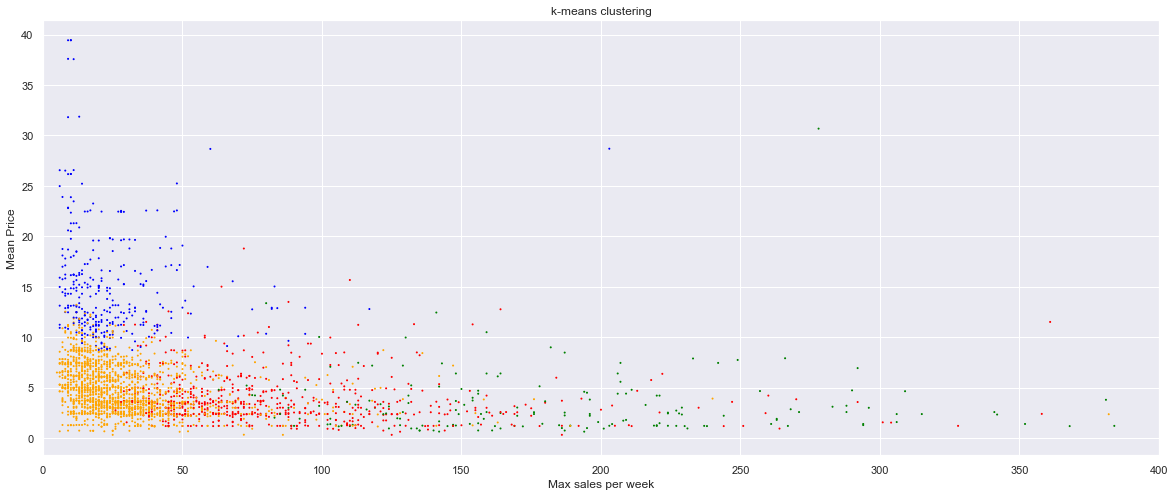

In [85]:

#%% Plot k-means clustering.
colores=['red','green','blue','orange']
asignar=[]
for row in X_processed['cluster']:
     asignar.append(colores[row])
plt.scatter(X_processed['max_sales_per_week'], X_processed['mean_precio'], c=asignar, s=1)
#plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='black', s=20) # Marco centroides.
plt.xlabel('Max sales per week')
plt.ylabel('Mean Price')
plt.title('k-means clustering')
plt.xlim(0,400)

plt.show()

en precio podemos ver 4 clusters diferentes. En terminos de Q solo distingo bien 3

<AxesSubplot:xlabel='mean_week_ventas', ylabel='Density'>

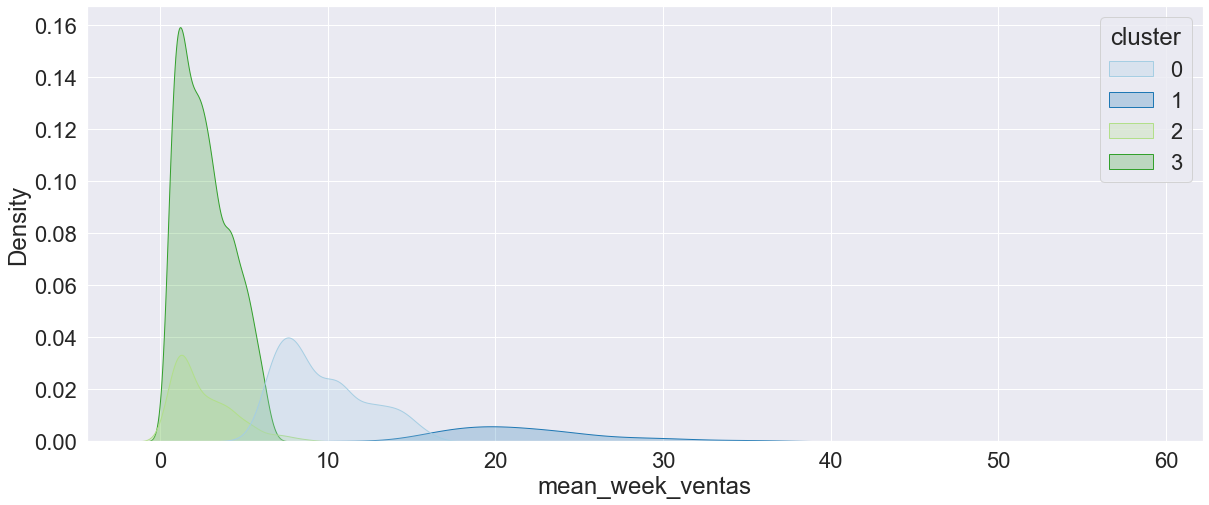

In [86]:
#Kernel Distribution Estimation Plot (KDE) : representa la función de densidad de probabilidad
#shade=True para resaltar el area debajo de la curva
#hay mayor densidad en precios entre 1 y 10
sns.set(font_scale = 2)
sns.kdeplot(X_processed['mean_week_ventas'], hue=X_processed['cluster'],shade=True,palette="Paired")  # para diferentes especies

La maxima cantidad de productos está en el cluster 2. Aun asi el cluster que da mayor revenue es el 1, seguido del 0

<AxesSubplot:xlabel='max_sales_per_week', ylabel='Density'>

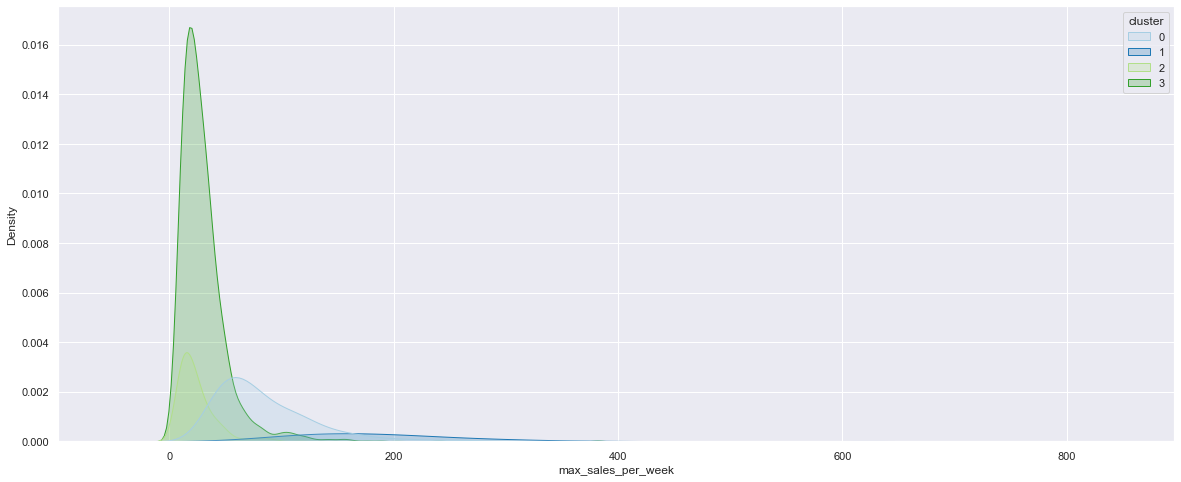

In [87]:
# lo hago con la venta media per week
sns.set(font_scale = 1)
sns.kdeplot(X_processed['max_sales_per_week'], hue=X_processed['cluster'],shade=True,palette="Paired")  # para diferentes especies

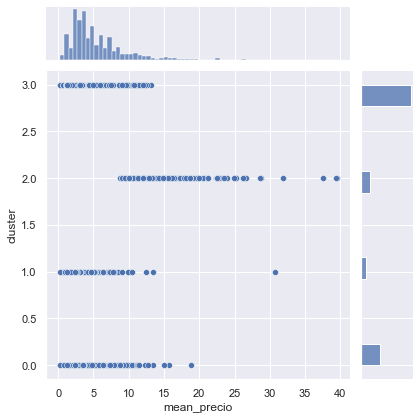

In [88]:

sns.jointplot(X_processed['mean_precio'],X_processed['cluster'])

In [89]:
#chequeo las columnas que tenemos para el gráfico que sigue
X_processed.columns

Index(['mean_week_ventas', 'max_precio', 'min_precio', 'mean_precio',
       'total_ventas', 'max_revenue', 'min_revenue', 'mean_revenue',
       'total_revenue', 'max_sales_per_week', 'ventas_en_New York',
       'ventas_en_Boston', 'ventas_en_Philadelphia', 'ventas_en_invierno',
       'ventas_en_primavera', 'ventas_en_verano', 'ventas_en_otoño',
       'venta_en_eventos', 'venta_Predidents_day', 'venta_Ramadan_starts',
       'venta_San_Patricio', 'venta_San_Valentin', 'venta_Superbowl',
       'venta_Thanksgiving', 'venta_Amazon_prime_day', 'venta_dia_de_la_indep',
       'venta_dia_madre', 'venta_dia_padre', 'cluster', 'id', 'category'],
      dtype='object')

Text(0.5, 0.98, 'Distribución de las variables usadas en el modelo')

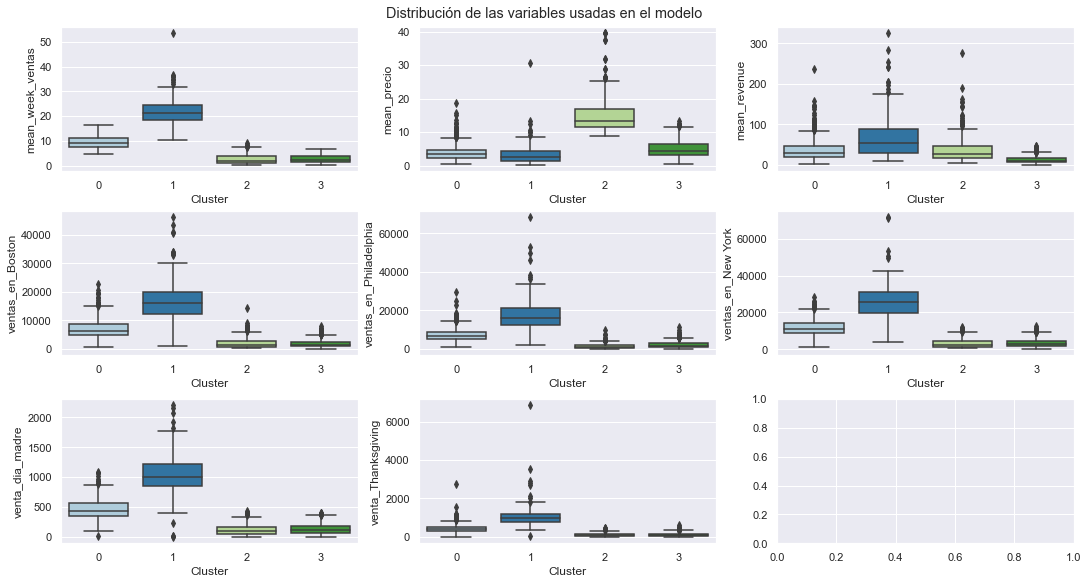

In [90]:
#tener en cuenta que cada gráf de caja tiene su propio eje Y. Van variando en fx de la variable
#datos_plot tiene la tabla con los clusters y tiene los productos como índices. Esto deberia ser un output
#para entregar a la empresa y que sepan qué productos corresponden a cada cluster.
cols = ["mean_week_ventas", "mean_precio", "mean_revenue", "ventas_en_Boston","ventas_en_Philadelphia","ventas_en_New York","venta_dia_madre","venta_Thanksgiving"]
datos_plot = df_items_sin_out[cols].copy(deep=True)
#datos_plot = datos[cols].copy(deep=True)
datos_plot["Cluster"] = labels

#X_processed['cluster'] = labels
fig, ax = plt.subplots(3,3, figsize=(15,8), constrained_layout=True)
for k, col_ in enumerate(cols):
    i = k//3
    j = k%3
  

    sns.boxplot(data=datos_plot, x="Cluster", y=col_, orient="v", ax=ax[i,j],palette="Paired")
fig.suptitle("Distribución de las variables usadas en el modelo")


In [91]:
df_items_sin_out

,mean_week_ventas,max_precio,min_precio,mean_precio,total_ventas,max_revenue,min_revenue,mean_revenue,total_revenue,max_sales_per_week,...,venta_Predidents_day,venta_Ramadan_starts,venta_San_Patricio,venta_San_Valentin,venta_Superbowl,venta_Thanksgiving,venta_Amazon_prime_day,venta_dia_de_la_indep,venta_dia_madre,venta_dia_padre
item,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001,1.491941,12.74,6.65,11.470806,4073,142.82,0.0,16.415956,44815.56,13,...,84,70,93,87,80,86,32,69,55,59
ACCESORIES_1_002,1.849817,5.28,2.66,5.276634,5050,195.36,0.0,9.765586,26660.05,37,...,104,102,86,88,81,91,22,95,59,90
ACCESORIES_1_003,0.523077,7.94,1.25,3.947520,1428,51.35,0.0,2.061740,5628.55,13,...,35,24,42,44,41,22,16,26,18,26
ACCESORIES_1_004,14.331502,6.17,5.01,5.977311,39125,450.50,0.0,86.101989,235058.43,73,...,844,600,924,789,833,723,119,721,735,773
ACCESORIES_1_005,5.343590,4.10,2.00,3.837557,14588,141.61,0.0,20.344824,55541.37,41,...,217,288,205,265,298,270,44,253,183,284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SUPERMARKET_3_823,5.630769,3.58,1.19,3.349282,15372,327.36,0.0,18.618462,50828.40,110,...,457,243,322,402,383,256,102,218,230,206
SUPERMARKET_3_824,3.046520,3.22,2.40,3.030747,8317,115.78,0.0,9.301593,25393.35,36,...,177,180,186,173,168,111,8,227,159,233
SUPERMARKET_3_825,4.945421,5.26,2.39,4.938106,13501,264.00,0.0,24.060440,65685.00,55,...,362,267,381,547,389,138,63,273,248,209


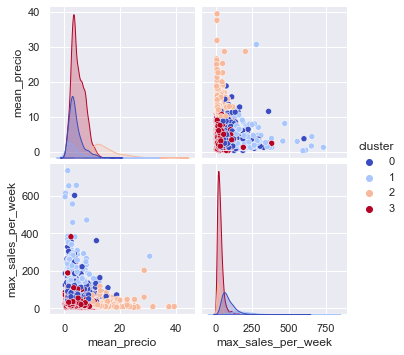

In [92]:
# Visualizamos nuestros grupos en base a las variables
# del modelo RFM, para ver que tal quedaron.
selected_columns = ['mean_precio',
                    'max_sales_per_week'
                   ]

g=sns.pairplot(X_processed,
             vars = selected_columns,
             hue = 'cluster',
            palette='coolwarm')



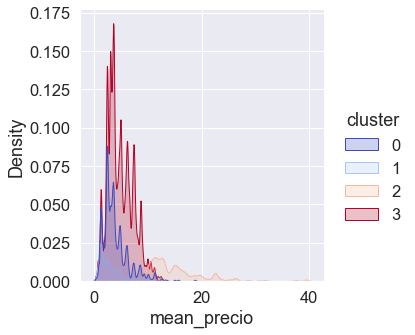

In [93]:
#gráfico para power BI
sns.set(font_scale = 1.5)
sns.displot(X_processed,x='mean_precio',kind='kde', hue='cluster', bw_adjust=.25,palette='coolwarm',fill=True) # mas menos ruido, como los bins en el histograma

In [94]:
X_processed

,mean_week_ventas,max_precio,min_precio,mean_precio,total_ventas,max_revenue,min_revenue,mean_revenue,total_revenue,max_sales_per_week,...,venta_San_Valentin,venta_Superbowl,venta_Thanksgiving,venta_Amazon_prime_day,venta_dia_de_la_indep,venta_dia_madre,venta_dia_padre,cluster,id,category
0,1.491941,12.74,6.65,11.470806,4073.0,142.82,0.0,16.415956,44815.56,13.0,...,87.0,80.0,86.0,32.0,69.0,55.0,59.0,2,ACCESORIES_1_001,ACCESORIES
1,1.849817,5.28,2.66,5.276634,5050.0,195.36,0.0,9.765586,26660.05,37.0,...,88.0,81.0,91.0,22.0,95.0,59.0,90.0,3,ACCESORIES_1_002,ACCESORIES
2,0.523077,7.94,1.25,3.947520,1428.0,51.35,0.0,2.061740,5628.55,13.0,...,44.0,41.0,22.0,16.0,26.0,18.0,26.0,3,ACCESORIES_1_003,ACCESORIES
3,14.331502,6.17,5.01,5.977311,39125.0,450.50,0.0,86.101989,235058.43,73.0,...,789.0,833.0,723.0,119.0,721.0,735.0,773.0,0,ACCESORIES_1_004,ACCESORIES
4,5.343590,4.10,2.00,3.837557,14588.0,141.61,0.0,20.344824,55541.37,41.0,...,265.0,298.0,270.0,44.0,253.0,183.0,284.0,3,ACCESORIES_1_005,ACCESORIES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2745,5.630769,3.58,1.19,3.349282,15372.0,327.36,0.0,18.618462,50828.40,110.0,...,402.0,383.0,256.0,102.0,218.0,230.0,206.0,3,SUPERMARKET_3_823,SUPERMARKET
2746,3.046520,3.22,2.40,3.030747,8317.0,115.78,0.0,9.301593,25393.35,36.0,...,173.0,168.0,111.0,8.0,227.0,159.0,233.0,3,SUPERMARKET_3_824,SUPERMARKET
2747,4.945421,5.26,2.39,4.938106,13501.0,264.00,0.0,24.060440,65685.00,55.0,...,547.0,389.0,138.0,63.0,273.0,248.0,209.0,3,SUPERMARKET_3_825,SUPERMARKET
2748,4.453480,1.54,1.20,1.539875,12158.0,50.69,0.0,6.840370,18674.21,33.0,...,198.0,259.0,151.0,78.0,265.0,265.0,298.0,3,SUPERMARKET_3_826,SUPERMARKET


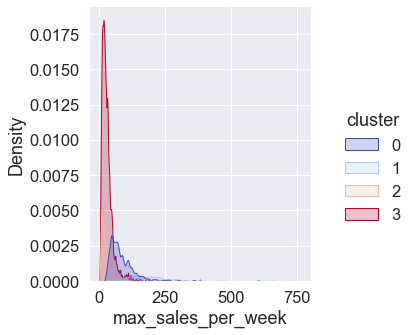

In [95]:
#gráfico para power BI
sns.set(font_scale = 1.5)

sns.displot(X_processed,x='max_sales_per_week',kind='kde', hue='cluster', bw_adjust=.25,palette='coolwarm',fill=True) # mas menos ruido, como los bins en el histograma

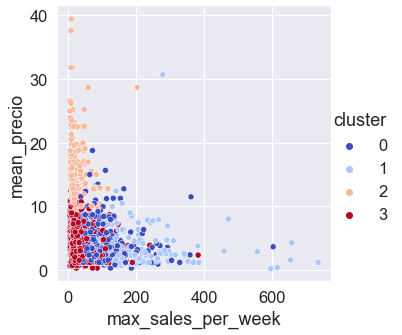

In [96]:
#gráfico para power BI
sns.set(font_scale = 1.5)

sns.relplot(x='max_sales_per_week',y='mean_precio',hue='cluster', data=X_processed,palette='coolwarm')

In [97]:
df_items.columns

Index(['mean_week_ventas', 'max_precio', 'min_precio', 'mean_precio',
       'total_ventas', 'max_revenue', 'min_revenue', 'mean_revenue',
       'total_revenue', 'max_sales_per_week', 'ventas_en_New York',
       'ventas_en_Boston', 'ventas_en_Philadelphia', 'ventas_en_invierno',
       'ventas_en_primavera', 'ventas_en_verano', 'ventas_en_otoño',
       'venta_en_eventos', 'venta_Predidents_day', 'venta_Ramadan_starts',
       'venta_San_Patricio', 'venta_San_Valentin', 'venta_Superbowl',
       'venta_Thanksgiving', 'venta_Amazon_prime_day', 'venta_dia_de_la_indep',
       'venta_dia_madre', 'venta_dia_padre'],
      dtype='object')

In [98]:
ficha_df = pd.DataFrame()

In [99]:
for i, col in enumerate(["mean_precio",
                         "max_sales_per_week",
                         "ventas_en_invierno",
                         'venta_Thanksgiving',
                         'max_revenue']):
    resumen_data = X_processed[["cluster", col]].groupby("cluster").describe().T[1:]
    ficha_df = ficha_df.append(resumen_data)

In [100]:
# generamos nuestro multiindexficha_df
out_index = [
    "Precio",
    "Cantidad",
    "Cantidad",
    'Cantidad',
    'Revenue'
]
inner_index = [
    "mean precio",
    "Max Cantidad vendida",
    "ventas invierno",
    'venta_Thanksgiving',
    'Max Revenue'
]

estadisticos = ["Media",
                "Desviación",
                "Mínimo",
                "Perc. 25",
                "Perc. 50",
                "Perc. 75",
                "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Precio', 'mean precio', 'Media'),
 ('Precio', 'mean precio', 'Desviación'),
 ('Precio', 'mean precio', 'Mínimo'),
 ('Precio', 'mean precio', 'Perc. 25'),
 ('Precio', 'mean precio', 'Perc. 50'),
 ('Precio', 'mean precio', 'Perc. 75'),
 ('Precio', 'mean precio', 'Máximo'),
 ('Cantidad', 'Max Cantidad vendida', 'Media'),
 ('Cantidad', 'Max Cantidad vendida', 'Desviación'),
 ('Cantidad', 'Max Cantidad vendida', 'Mínimo'),
 ('Cantidad', 'Max Cantidad vendida', 'Perc. 25'),
 ('Cantidad', 'Max Cantidad vendida', 'Perc. 50'),
 ('Cantidad', 'Max Cantidad vendida', 'Perc. 75'),
 ('Cantidad', 'Max Cantidad vendida', 'Máximo'),
 ('Cantidad', 'ventas invierno', 'Media'),
 ('Cantidad', 'ventas invierno', 'Desviación'),
 ('Cantidad', 'ventas invierno', 'Mínimo'),
 ('Cantidad', 'ventas invierno', 'Perc. 25'),
 ('Cantidad', 'ventas invierno', 'Perc. 50'),
 ('Cantidad', 'ventas invierno', 'Perc. 75'),
 ('Cantidad', 'ventas invierno', 'Máximo'),
 ('Cantidad', 'venta_Thanksgiving', 'Media'),
 ('Cantida

In [101]:
ficha_df

cluster                             0             1            2            3
mean_precio        mean      3.910698      3.308113    15.149827     4.820451
                   std       2.489308      3.169990     5.418777     2.347195
                   min       0.311700      0.240648     8.715308     0.310000
                   25%       2.369196      1.260945    11.400139     3.004388
                   50%       3.327866      2.432751    13.160652     4.350000
                   75%       4.782275      4.270687    17.005410     6.419033
                   max      18.786132     30.676923    39.446502    13.200568
max_sales_per_week mean     87.102894    200.229050    24.579288    30.078049
                   std      53.234864    109.709310    19.965661    23.528934
                   min      26.000000     63.000000     6.000000     5.000000
                   25%      52.000000    132.000000    12.000000    16.000000
                   50%      72.500000    176.000000    19.000000    25.000000
                   75%     108.000000    228.500000    29.000000    36.000000
                   max     602.000000    734.000000   203.000000   382.000000
ventas_en_invierno mean   7188.754019  16452.094972  1913.313916  2002.898780
                   std    2150.547896   4888.615200  1367.326824  1219.819705
                   min    2470.000000   3663.000000   146.000000    11.000000
                   25%    5531.750000  13308.500000   858.000000   975.500000
                   50%    6723.500000  15860.000000  1506.000000  1797.500000
                   75%    8723.500000  18082.000000  2726.000000  2835.750000
                   max   15806.000000  47408.000000  8288.000000  6342.000000
venta_Thanksgiving mean    436.718650   1061.899441   117.446602   119.469512
                   std     209.508734    621.527333    90.526748    79.318784
                   min       0.000000     17.000000     1.000000     0.000000
                   25%     310.000000    776.500000    54.000000    57.000000
                   50%     392.500000    962.000000    91.000000   107.000000
                   75%     528.000000   1198.000000   162.000000   168.000000
                   max    2740.000000   6850.000000   464.000000   634.000000
max_revenue        mean    316.825370    619.196592   362.826828   127.223171
                   std     303.315107    785.660577   416.093459   100.130318
                   min      35.480000     94.430000    66.450000     3.990000
                   25%     157.305000    239.350000   182.600000    69.572500
                   50%     236.100000    416.060000   254.880000   104.550000
                   75%     374.325000    782.545000   414.610000   152.037500
                   max    4189.040000   8496.630000  6204.370000  1184.900000

In [102]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [103]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [104]:
tamaño_clusters = X_processed.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [105]:
tamaño_clusters

,,cluster,0,1,2,3
Grupo Indicadores,Indicador,Estadístico,,,,
General,Clúster,Tamaño,622,179,309,1640


In [106]:
ficha_df = tamaño_clusters.append(ficha_df)

In [107]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [109]:
X_processed.head(2)

,mean_week_ventas,max_precio,min_precio,mean_precio,total_ventas,max_revenue,min_revenue,mean_revenue,total_revenue,max_sales_per_week,...,venta_San_Valentin,venta_Superbowl,venta_Thanksgiving,venta_Amazon_prime_day,venta_dia_de_la_indep,venta_dia_madre,venta_dia_padre,cluster,id,category
0,1.49,12.74,6.65,11.47,4073.0,142.82,0.0,16.42,44815.56,13.0,...,87.0,80.0,86.0,32.0,69.0,55.0,59.0,2,ACCESORIES_1_001,ACCESORIES
1,1.85,5.28,2.66,5.28,5050.0,195.36,0.0,9.77,26660.05,37.0,...,88.0,81.0,91.0,22.0,95.0,59.0,90.0,3,ACCESORIES_1_002,ACCESORIES


In [111]:
X_processed.to_csv(f'{DATA_PATH}/df_clusters.csv')